<a href="https://colab.research.google.com/github/jcd1141/cs417/blob/main/labs/Lab9/notebooks/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9: Open Addressing Analysis

In this notebook you'll run experiments on your `HashTableOpen` class to see how linear probing behaves under different conditions.

**Step 1:** Paste your completed `HashTableOpen` class (including the `_TOMBSTONE` sentinel) into the cell below.

In [1]:
# ── Paste your HashTableOpen class here ──────────────────────────
# Copy everything from src/hash_table_open.py and paste it below.
# Include the _TOMBSTONE = object() line at the top.
"""
Lab 9: Open Addressing with Linear Probing

In this lab you will implement a hash table that uses open addressing
instead of separate chaining. Every item lives directly in the table
array — no lists of pairs, just one item per slot.

When a collision happens, you probe forward (linear probing) to find
the next available slot. Deletion uses tombstones to preserve probe chains.

Complete the four methods marked with TODO.
Do NOT change the method signatures or the __init__ method.

Run tests:
    pytest -v
"""

# Sentinel value for deleted slots. Do not modify.
_TOMBSTONE = object()


class HashTableOpen:
    """A hash table using open addressing with linear probing."""

    def __init__(self, size=10):
        """Create an empty hash table with the given number of slots."""
        self.size = size
        self.table = [None] * self.size
        self.count = 0

    # ── TODO 1: Hash Function ─────────────────────────────────────

    def _hash(self, key):
        """
        Return a slot index for the given key.

        Use Python's built-in hash() function and modulo (%) to map
        the key to a valid index in range [0, self.size).

        Args:
            key: The key to hash (any hashable type).

        Returns:
            int: A slot index between 0 and self.size - 1.
        """
        # TODO: implement this (1 line)
        return hash(key) % self.size

    # ── TODO 2: Put ───────────────────────────────────────────────

    def put(self, key, value):
        """
        Insert or update a key-value pair using linear probing.

        Algorithm:
            1. Compute the starting index with _hash(key).
            2. Probe forward through the table:
               - If the slot is None or _TOMBSTONE → place (key, value) here.
               - If the slot has a matching key → update the value.
               - Otherwise → move to the next slot (wrap around with %).
            3. Increment self.count only when adding a NEW key.
            4. Raise Exception("Hash table is full") if no slot is found.

        Hint: for step in range(self.size) lets you try every slot once.
              index = (start + step) % self.size handles the wrap-around.

        Args:
            key:   The key to insert.
            value: The value to associate with the key.
        """
        # TODO: implement this
        start = self._hash(key)

        for step in range(self.size):
            index = (start + step) % self.size
            slot = self.table[index]

            if slot is None or slot is _TOMBSTONE:
                self.table[index] = (key, value)
                self.count += 1
                return

            k, _ = slot
            if k == key:
                self.table[index] = (key, value)
                return

        raise Exception("Hash table is full")

    # ── TODO 3: Get ───────────────────────────────────────────────

    def get(self, key):
        """
        Look up a value by key, following the probe chain.

        Algorithm:
            1. Start at _hash(key).
            2. Probe forward:
               - Matching key → return the value.
               - None → key not in table → raise KeyError.
               - _TOMBSTONE → skip it, keep probing.
               - Different key → keep probing.
            3. Raise KeyError if you've checked every slot.

        Important: Tombstones do NOT stop the search. Only None stops it.

        Args:
            key: The key to look up.

        Returns:
            The value associated with the key.

        Raises:
            KeyError: If the key is not found.
        """
        # TODO: implement this
        start = self._hash(key)

        for step in range(self.size):
            index = (start + step) % self.size
            slot = self.table[index]

            if slot is None:
                raise KeyError(key)

            if slot is _TOMBSTONE:
                continue

            k, v = slot
            if k == key:
                return v

        raise KeyError(key)

    # ── TODO 4: Delete ────────────────────────────────────────────

    def delete(self, key):
        """
        Remove a key-value pair by replacing it with a tombstone.

        Why not just set the slot to None? Because it would break probe
        chains — any keys that were placed AFTER this slot (due to
        collisions) would become unreachable.

        Algorithm:
            1. Start at _hash(key), probe forward (like get).
            2. If you find the matching key → replace with _TOMBSTONE,
               decrement self.count.
            3. If you hit None or exhaust the table → raise KeyError.

        Args:
            key: The key to remove.

        Raises:
            KeyError: If the key is not found.
        """
        # TODO: implement this
        start = self._hash(key)

        for step in range(self.size):
            index = (start + step) % self.size
            slot = self.table[index]

            if slot is None:
                raise KeyError(key)

            if slot is _TOMBSTONE:
                continue

            k, _ = slot
            if k == key:
                self.table[index] = _TOMBSTONE
                self.count -= 1
                return

        raise KeyError(key)

    # ── Provided Methods (do not modify) ──────────────────────────

    def __len__(self):
        """Return the number of key-value pairs in the table."""
        return self.count

    def __contains__(self, key):
        """Support 'in' operator: key in table."""
        try:
            self.get(key)
            return True
        except KeyError:
            return False

    def load_factor(self):
        """Return the current load factor (items / slots)."""
        return self.count / self.size

    def __repr__(self):
        """Show a readable view of the hash table's internal state."""
        lines = []
        for i, slot in enumerate(self.table):
            if slot is None:
                lines.append(f"  [{i}] empty")
            elif slot is _TOMBSTONE:
                lines.append(f"  [{i}] TOMBSTONE")
            else:
                k, v = slot
                lines.append(f"  [{i}] {k!r}: {v!r}")
        return f"HashTableOpen({self.count} items, {self.size} slots):\n" + "\n".join(lines)

## Experiment 1: Counting Probes

How many probes (slot checks) does it take to insert items as the table fills up?

Run the cell below. It inserts random keys into a table of size 100 and tracks how many probes each `put` requires. The chart shows how probe count grows as load factor increases.

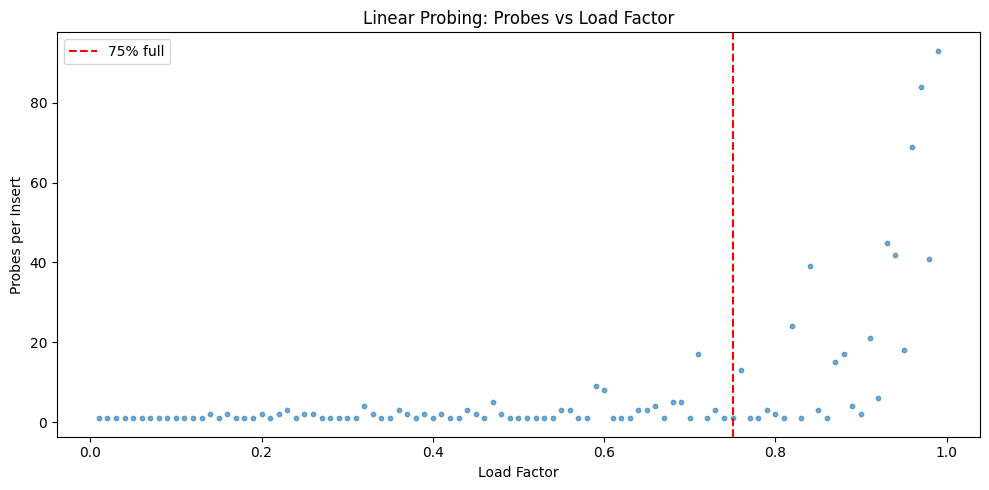

Average probes at <50% load: 1.5
Average probes at >75% load: 22.8


In [2]:
import random
import matplotlib.pyplot as plt

def count_probes_on_put(ht, key, value):
    """Insert a key and return how many slots were checked."""
    start = ht._hash(key)
    probes = 0
    for step in range(ht.size):
        idx = (start + step) % ht.size
        probes += 1
        slot = ht.table[idx]
        if slot is None or slot is ht.__class__.__module__ and False:
            break
        if isinstance(slot, tuple) and slot[0] == key:
            break
    ht.put(key, value)
    return probes

# Run experiment
SIZE = 100
ht = HashTableOpen(size=SIZE)
load_factors = []
probe_counts = []

random.seed(42)
for i in range(SIZE - 1):  # fill to 99% (can't fill 100%)
    key = f"key_{random.randint(0, 999999)}"
    probes = count_probes_on_put(ht, key, i)
    load_factors.append(ht.load_factor())
    probe_counts.append(probes)

plt.figure(figsize=(10, 5))
plt.scatter(load_factors, probe_counts, s=10, alpha=0.6)
plt.xlabel('Load Factor')
plt.ylabel('Probes per Insert')
plt.title('Linear Probing: Probes vs Load Factor')
plt.axvline(x=0.75, color='red', linestyle='--', label='75% full')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average probes at <50% load: {sum(p for l,p in zip(load_factors, probe_counts) if l < 0.5) / max(1, sum(1 for l in load_factors if l < 0.5)):.1f}")
print(f"Average probes at >75% load: {sum(p for l,p in zip(load_factors, probe_counts) if l > 0.75) / max(1, sum(1 for l in load_factors if l > 0.75)):.1f}")

**Question:** What happens to the number of probes once the table is more than 75% full? Why does this happen?

*Your answer:*
The amount of probes per insert grows a lot more. This is because collisions are more frequent and there are less slots available at this point.

## Experiment 2: Visualize the Table

Let's see what the table actually looks like at different load factors. Green = occupied, red = tombstone, gray = empty.

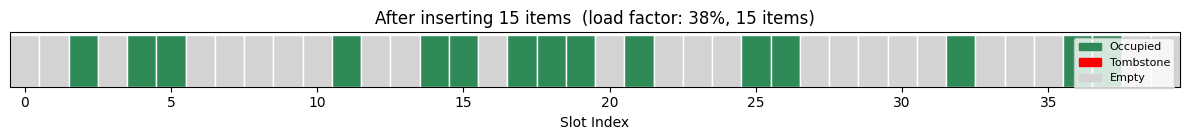

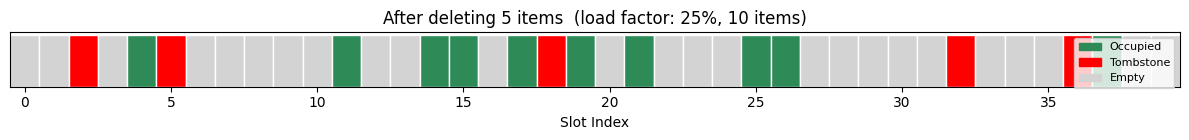

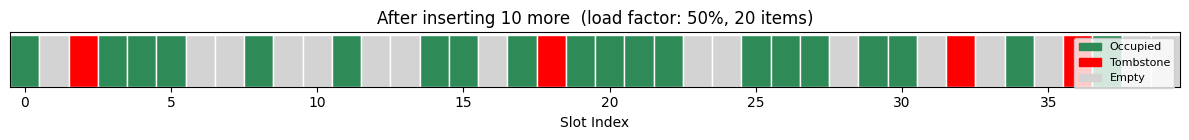

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_table(ht, title=""):
    """Show the table as a color-coded bar."""
    colors = []
    for slot in ht.table:
        if slot is None:
            colors.append('lightgray')
        elif slot is _TOMBSTONE:
            colors.append('red')
        else:
            colors.append('seagreen')

    fig, ax = plt.subplots(figsize=(12, 1.5))
    ax.bar(range(len(colors)), [1]*len(colors), color=colors, edgecolor='white', width=1.0)
    ax.set_xlim(-0.5, len(colors)-0.5)
    ax.set_yticks([])
    ax.set_xlabel('Slot Index')
    ax.set_title(f'{title}  (load factor: {ht.load_factor():.0%}, {ht.count} items)')

    legend = [
        mpatches.Patch(color='seagreen', label='Occupied'),
        mpatches.Patch(color='red', label='Tombstone'),
        mpatches.Patch(color='lightgray', label='Empty'),
    ]
    ax.legend(handles=legend, loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()

# Build a table and visualize at different stages
SIZE = 40
ht = HashTableOpen(size=SIZE)

# Insert 15 items
random.seed(7)
keys = [f"item_{random.randint(0, 9999)}" for _ in range(15)]
for k in keys:
    ht.put(k, True)
visualize_table(ht, "After inserting 15 items")

# Delete 5 items
for k in keys[:5]:
    ht.delete(k)
visualize_table(ht, "After deleting 5 items")

# Insert 10 more
for i in range(10):
    ht.put(f"new_{i}", True)
visualize_table(ht, "After inserting 10 more")

**Question:** Look at the "After deleting 5 items" visualization. Do you see any clusters (groups of green slots next to each other)? Why do clusters form with linear probing?

*Your answer:*
Yes, you can see clusters where many green slots are next to each other. These clusters form because with linear probing, when a key collides, it just moves to the next open slot. More keys keep landing in the same area, so those groups of filled slots get bigger.

## Experiment 3: Chaining vs Open Addressing

How does lookup time compare between the two approaches? We'll measure the average number of comparisons for `get()` at different load factors.

We provide a simple chaining implementation below to compare against your open addressing table.

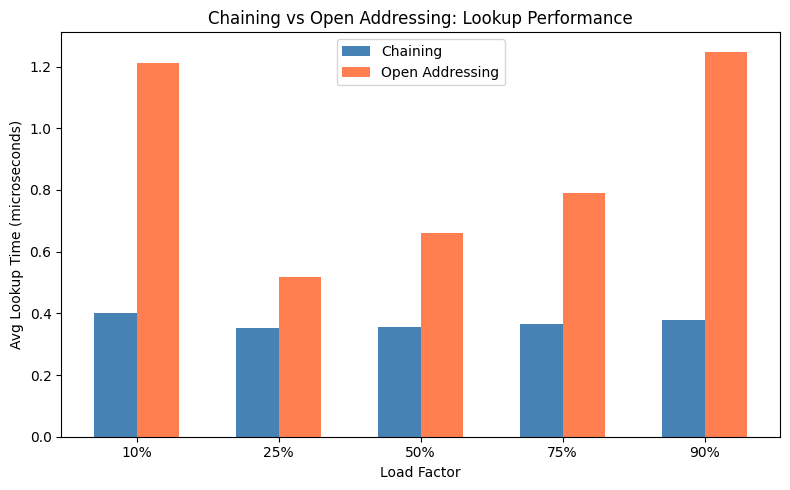

Load Factor | Chaining (us) | Open Addr (us)
---------------------------------------------
    10%      |    0.40       |    1.21
    25%      |    0.35       |    0.52
    50%      |    0.36       |    0.66
    75%      |    0.37       |    0.79
    90%      |    0.38       |    1.25


In [4]:
import time

class ChainingHashTable:
    """Simple chaining hash table for comparison."""
    def __init__(self, size=100):
        self.size = size
        self.table = [[] for _ in range(size)]
        self.count = 0

    def _hash(self, key):
        return hash(key) % self.size

    def put(self, key, value):
        bucket = self.table[self._hash(key)]
        for pair in bucket:
            if pair[0] == key:
                pair[1] = value
                return
        bucket.append([key, value])
        self.count += 1

    def get(self, key):
        for pair in self.table[self._hash(key)]:
            if pair[0] == key:
                return pair[1]
        raise KeyError(key)

# Compare lookup times at different load factors
SIZE = 1000
load_targets = [0.1, 0.25, 0.5, 0.75, 0.9]
chaining_times = []
probing_times = []

for target in load_targets:
    n_items = int(SIZE * target)
    keys = [f"k{i}" for i in range(n_items)]

    # Build both tables
    chain_ht = ChainingHashTable(size=SIZE)
    open_ht = HashTableOpen(size=SIZE)
    for k in keys:
        chain_ht.put(k, True)
        open_ht.put(k, True)

    # Time lookups
    start = time.perf_counter()
    for k in keys:
        chain_ht.get(k)
    chaining_times.append((time.perf_counter() - start) / n_items * 1_000_000)

    start = time.perf_counter()
    for k in keys:
        open_ht.get(k)
    probing_times.append((time.perf_counter() - start) / n_items * 1_000_000)

# Plot
plt.figure(figsize=(8, 5))
x = range(len(load_targets))
plt.bar([i - 0.15 for i in x], chaining_times, width=0.3, label='Chaining', color='steelblue')
plt.bar([i + 0.15 for i in x], probing_times, width=0.3, label='Open Addressing', color='coral')
plt.xticks(x, [f"{int(t*100)}%" for t in load_targets])
plt.xlabel('Load Factor')
plt.ylabel('Avg Lookup Time (microseconds)')
plt.title('Chaining vs Open Addressing: Lookup Performance')
plt.legend()
plt.tight_layout()
plt.show()

print("Load Factor | Chaining (us) | Open Addr (us)")
print("-" * 45)
for t, c, o in zip(load_targets, chaining_times, probing_times):
    print(f"    {t:.0%}      |    {c:.2f}       |    {o:.2f}")

**Question:** At which load factor does open addressing start to perform worse than chaining? Why does chaining handle high load factors more gracefully?

*Your answer:*
Open addressing usually starts to perform worse around 75% load and gets much worse by 90%. That’s because linear probing creates long clusters, so lookups have to scan through a lot of filled slots. Chaining handles high load better since collisions just add items to a bucket instead of creating long runs across the table.